In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os


In [2]:
input_path = "../data/raw/raw_data.csv"
chunksize = 10000

Basic Information

In [10]:
first_chunk = pd.read_csv(input_path, nrows=chunksize)
print(first_chunk.head())
print(first_chunk.dtypes)
print(first_chunk.columns)
print(first_chunk.shape)

  ticker rpa_date_utc rpa_time_utc rp_entity_id  entity_name  relevance  \
0    HUM   2025-01-03     15:52:08       00067A  Humana Inc.        100   
1    HUM   2025-01-06     13:38:43       00067A  Humana Inc.        100   
2    HUM   2025-01-06     13:38:43       00067A  Humana Inc.        100   
3    HUM   2025-01-09     21:30:01       00067A  Humana Inc.        100   
4    HUM   2025-01-09     21:30:01       00067A  Humana Inc.        100   

   event_sentiment_score            group sub_type  \
0                  -0.49  insider-trading      NaN   
1                   0.00  analyst-ratings  neutral   
2                   0.78    price-targets  upgrade   
3                   0.00         earnings      NaN   
4                   0.00         earnings      NaN   

                                          event_text      news_type  \
0            Officer Huval Sells 3,703 Of Humana Inc   FULL-ARTICLE   
1  Humana Is Maintained at Hold by Truist Securities     NEWS-FLASH   
2  Humana P

In [11]:
total_rows = 0
missing_counts = {}
numeric_stats = {}
text_lengths = []
sentiment_scores = []

required_cols = ['headline', 'event_sentiment_score']
chunk_iter = pd.read_csv(input_path, chunksize=chunksize, low_memory=False)

for chunk_idx, chunk in enumerate(tqdm(chunk_iter, desc="processing")):
    total_rows += len(chunk)
    
    # NaNs
    for col in chunk.columns:
        if col not in missing_counts:
            missing_counts[col] = 0
        missing_counts[col] += chunk[col].isna().sum()
    
    # sentiment score
    if 'event_sentiment_score' in chunk.columns:
        valid_scores = chunk['event_sentiment_score'].dropna().astype(float)
        sentiment_scores.extend(valid_scores.tolist())
    
    # text length
    if 'headline' in chunk.columns:
        chunk_texts = chunk['headline'].dropna().astype(str)
        if len(chunk_texts) > 0:
            lengths = chunk_texts.str.len()
            text_lengths.extend(lengths.tolist())
            if len(text_lengths) > 100000:
                text_lengths = np.random.choice(text_lengths, 100000, replace=False).tolist()

print(f"\ntotal rows: {total_rows:,}")
print(f"\nmissing values:")
for col, count in sorted(missing_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    percentage = count / total_rows * 100
    print(f"  {col}: {count:,} ({percentage:.2f}%)")

processing: 10656it [12:11, 14.57it/s]


total rows: 106,554,466

missing values:
  sub_type: 34,848,308 (32.70%)
  ticker: 0 (0.00%)
  rpa_date_utc: 0 (0.00%)
  rpa_time_utc: 0 (0.00%)
  rp_entity_id: 0 (0.00%)
  entity_name: 0 (0.00%)
  relevance: 0 (0.00%)
  event_sentiment_score: 0 (0.00%)
  group: 0 (0.00%)
  event_text: 0 (0.00%)


Emotion Distribution

In [13]:
sentiment_array = np.array(sentiment_scores)
print(f"length: {len(sentiment_array):,}")
print(f"min: {sentiment_array.min():.4f}")
print(f"0.25quarter: {np.percentile(sentiment_array, 25):.4f}")
print(f"median: {np.median(sentiment_array):.4f}")
print(f"0.75quarter: {np.percentile(sentiment_array, 75):.4f}")
print(f"max: {sentiment_array.max():.4f}")
print(f"average: {sentiment_array.mean():.4f}")
print(f"std: {sentiment_array.std():.4f}")
    
# index
positive = (sentiment_array > 0.2).sum()
negative = (sentiment_array < -0).sum()
neutral = ((sentiment_array >= 0) & (sentiment_array <= 0.2)).sum()
    

print(f"  positive (>0.1): {positive:,} ({positive/len(sentiment_array)*100:.2f}%)")
print(f"  negative (<-0.1): {negative:,} ({negative/len(sentiment_array)*100:.2f}%)")
print(f"  neutral (-0.1~0.1): {neutral:,} ({neutral/len(sentiment_array)*100:.2f}%)")

length: 106,554,466
min: -1.0000
0.25quarter: 0.0000
median: 0.0000
0.75quarter: 0.0000
max: 1.0000
average: 0.0676
std: 0.2826
  positive (>0.1): 22,571,757 (21.18%)
  negative (<-0.1): 8,709,793 (8.17%)
  neutral (-0.1~0.1): 75,272,916 (70.64%)


Length Distribution

In [14]:
text_length_array = np.array(text_lengths)
print(f"length (based on {len(text_length_array):,} samples):")
print(f"min: {text_length_array.min()}")
print(f"0.25quarter: {np.percentile(text_length_array, 25):.1f}")
print(f"median: {np.median(text_length_array):.1f}")
print(f"0.75quarter: {np.percentile(text_length_array, 75):.1f}")
print(f"max: {text_length_array.max()}")
print(f"mean: {text_length_array.mean():.1f}")

length (based on 100,000 samples):
min: 21
0.25quarter: 62.0
median: 78.0
0.75quarter: 100.0
max: 224
mean: 83.1


visualization

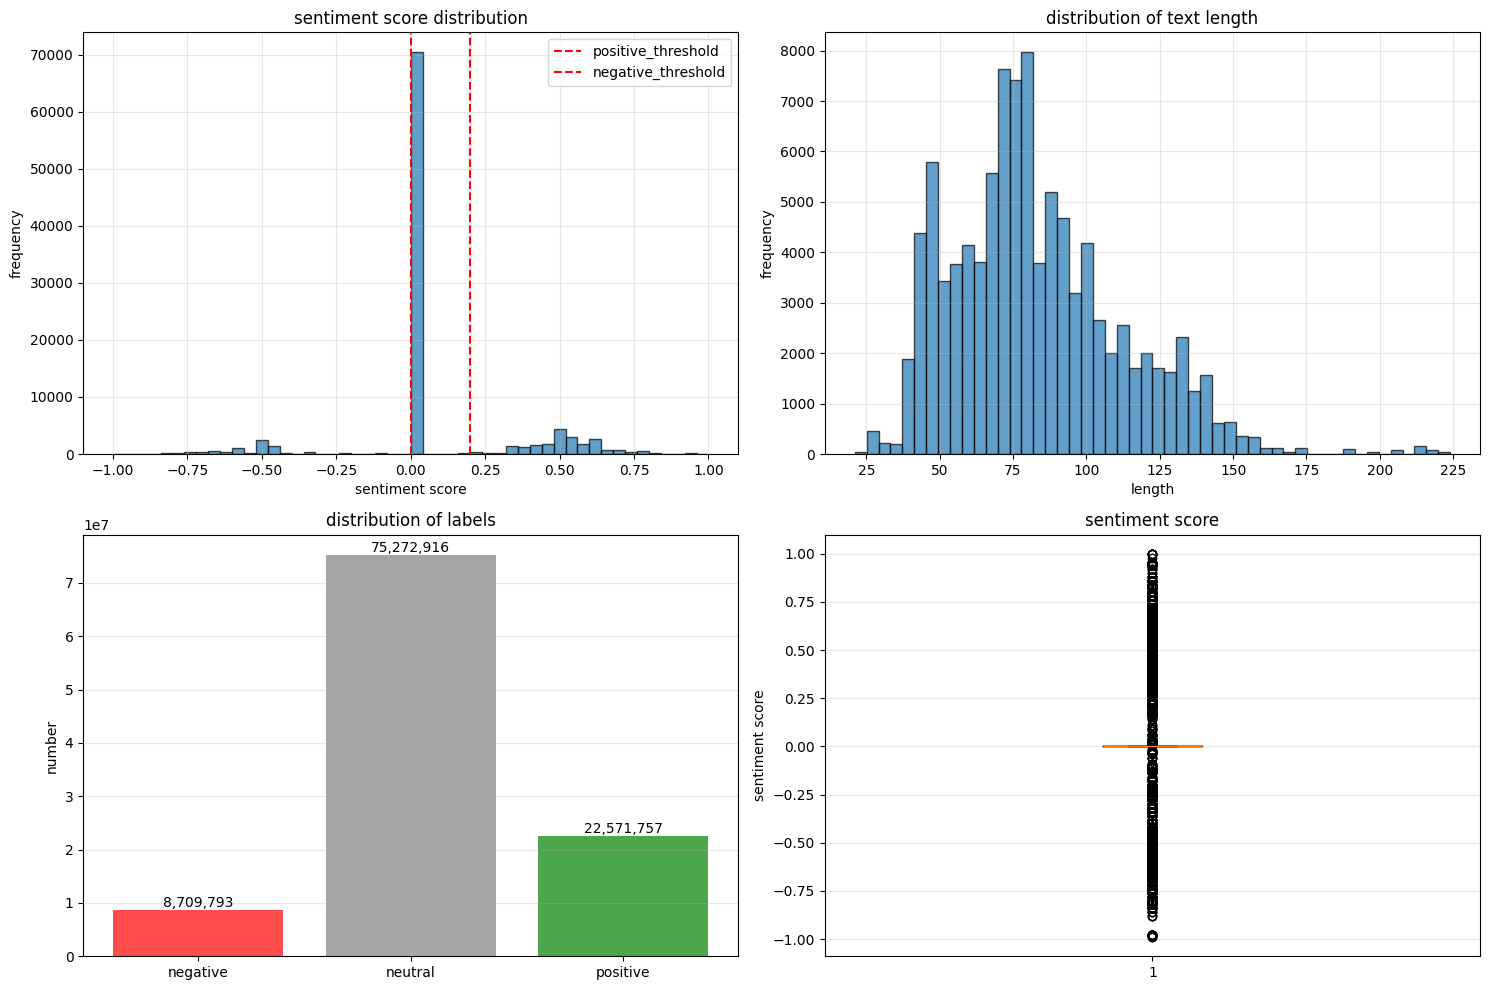

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

if len(sentiment_scores) > 0:
    plot_scores = sentiment_array if len(sentiment_array) <= 100000 else np.random.choice(sentiment_array, 100000)
    axes[0, 0].hist(plot_scores, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(x=0.2, color='r', linestyle='--', label='positive_threshold')
    axes[0, 0].axvline(x=0, color='r', linestyle='--', label='negative_threshold')
    axes[0, 0].set_xlabel('sentiment score')
    axes[0, 0].set_ylabel('frequency')
    axes[0, 0].set_title('sentiment score distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

if len(text_lengths) > 0:
    plot_lengths = text_length_array if len(text_length_array) <= 100000 else np.random.choice(text_length_array, 100000)
    axes[0, 1].hist(plot_lengths, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('length')
    axes[0, 1].set_ylabel('frequency')
    axes[0, 1].set_title('distribution of text length')
    axes[0, 1].grid(True, alpha=0.3)

if len(sentiment_scores) > 0:
    labels = ['negative', 'neutral', 'positive']
    counts = [negative, neutral, positive]
    axes[1, 0].bar(labels, counts, color=['red', 'gray', 'green'], alpha=0.7)
    axes[1, 0].set_ylabel('number')
    axes[1, 0].set_title('distribution of labels')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    for i, count in enumerate(counts):
        axes[1, 0].text(i, count, f'{count:,}', ha='center', va='bottom')

if len(sentiment_scores) > 0:
    plot_scores = sentiment_array if len(sentiment_array) <= 50000 else np.random.choice(sentiment_array, 50000)
    axes[1, 1].boxplot(plot_scores, vert=True)
    axes[1, 1].set_ylabel('sentiment score')
    axes[1, 1].set_title('sentiment score')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()